In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.keras.layers import Dense, Dropout, LSTM,Conv1D, TimeDistributed, Flatten, SpatialDropout1D, GlobalAveragePooling1D, SimpleRNN, MaxPooling1D, GlobalMaxPooling1D, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, f1_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, precision_score, classification_report
from numpy import sqrt
from numpy import argmax
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
from numpy import genfromtxt

/Users/niall/opt/anaconda3/envs/DCUML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/niall/opt/anaconda3/envs/DCUML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/niall/opt/anaconda3/envs/DCUML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/niall/opt/anaconda3/envs/DCUML

In [2]:
def get_data():
    input_file = '/Users/niall/Documents/Cypress_Code/Data/Multipath/multi_test_one.csv'
    my_data_flipped = genfromtxt(input_file, delimiter=',')

    new_data = np.delete(my_data_flipped, (0), axis=0)
    X2 = np.delete(new_data, (0,39), axis=1)
    Y2 = new_data[:,39]
    X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=0.25, random_state=42, shuffle=True)
    X_train = np.array(X_train).reshape((np.shape(X_train)[0], 1, np.shape(X_train)[1]))
    X_test = np.array(X_test).reshape((np.shape(X_test)[0], 1, np.shape(X_test)[1]))

    return X_train, X_test, y_train, y_test

In [3]:
flip_bit_data = get_data()

In [4]:
X_train = flip_bit_data[0]
X_test = flip_bit_data[1]
y_train = flip_bit_data[2]
y_test = flip_bit_data[3]

In [5]:
num_neurons = 38
num_features = 38

model_rnn = Sequential()
model_rnn.add(SimpleRNN(num_neurons, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, input_shape=(1, num_features)))
model_rnn.add(GlobalMaxPooling1D())
model_rnn.add(Dense(16, activation='sigmoid'))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(1, activation='sigmoid'))


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rnn.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1, 38)             2926      
_________________________________________________________________
global_max_pooling1d (Global (None, 38)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                624       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 3,567
Trainable params: 3,567
Non-trainable params: 0
___________________

In [6]:
batch_size = 5
history_rnn = model_rnn.fit(X_train, y_train, 
                            batch_size=batch_size, 
                            epochs=5, 
                            validation_data=(X_test, y_test), 
                            callbacks=[rlrp],
                            verbose=1)

Train on 15000 samples, validate on 5000 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/5
15000/15000 [==============================] - 6s 415us/sample - loss: 0.2445 - acc: 0.9083 - val_loss: 0.1438 - val_acc: 0.9482
Epoch 2/5
15000/15000 [==============================] - 5s 356us/sample - loss: 0.1891 - acc: 0.9286 - val_loss: 0.1331 - val_acc: 0.9538
Epoch 3/5
15000/15000 [==============================] - 5s 358us/sample - loss: 0.1802 - acc: 0.9339 - val_loss: 0.1304 - val_acc: 0.9546
Epoch 4/5
15000/15000 [==============================] - 5s 359us/sample - loss: 0.1768 - acc: 0.9347 - val_loss: 0.1267 - val_acc: 0.9530
Epoch 5/5
15000/15000 [==============================] - 6s 391us/sample - loss: 0.1720 - acc: 0.9357 - val_loss: 0.1214 - val_acc: 0.9552


5000/5000 [==============================] - 0s 30us/sample - loss: 0.1214 - acc: 0.9552
Test Loss:  0.12141748967170715
Test Accuracy 0.9552
dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


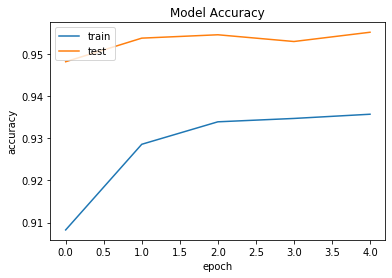

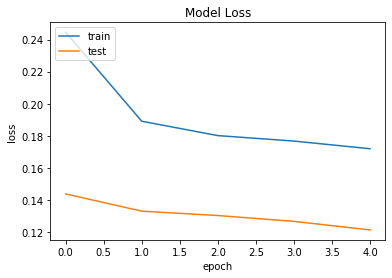

In [7]:
score = model_rnn.evaluate(X_test, y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])

print(history_rnn.history.keys())

plt.plot(history_rnn.history['acc'])
plt.plot(history_rnn.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
yhat = model_rnn.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, yhat)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)

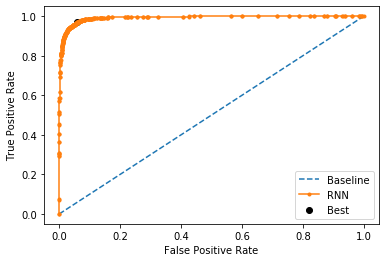

In [15]:
plt.plot([0,1], [0,1], linestyle='--', label='Baseline')
plt.plot(fpr, tpr, marker='.', label='RNN')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.savefig('/Users/niall/Documents/Cypress_Code/Plots/Multipath/RNN_ROC.png')
plt.show()


In [13]:
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print('ROC AUC=%.3f' % (roc_auc_score(y_test, yhat_new)))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
    
yhat_new = model_rnn.predict_classes(X_test)
metrics(yhat_new, y_test)

F1-score:  0.9563012095200938
Precision:  0.9710776545166403
Recall:  0.9419677171406611
Acuracy:  0.9552
ROC AUC=0.955
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2398
           1       0.97      0.94      0.96      2602

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



In [ ]:
y_preds_rnn = model_avg_from_disc.predict(X_test, batch_size=1)

In [ ]:
pred_avg = pd.DataFrame(y_preds_rnn, columns =['Y_pred']) 
pred_avg['Label'] = y_test

In [ ]:
pred_avg.to_csv('/Users/niall/Documents/Cypress_Code/Predictions/RNN/Multipath/model_one_rnn_channel_one.csv', index = False)

In [ ]:
json = model_rnn.to_json()
with open("/Users/niall/Documents/Cypress_Code/Models/RNN/Multipath/model_one_rnn_channel_one.json", "w") as file:
    file.write(json)
model_rnn.save_weights("/Users/niall/Documents/Cypress_Code/Models/RNN/Multipath/model_one_rnn_channel_one.h5")
print("Saved model to disc")

In [ ]:
# Load the model of interest
json_file = open('/Users/niall/Documents/Cypress_Code/Models/RNN/Multipath/model_one_rnn_channel_one.json', 'r')
json = json_file.read()
json_file.close()
model_avg_from_disc = model_from_json(json)
model_avg_from_disc.load_weights("//Users/niall/Documents/Cypress_Code/Models/RNN/Multipath/model_one_rnn_channel_one.h5")